In [24]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import scipy.io
import pandas as pd
import h5py
# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/users/marianne/documents/pe_snow_fires/')

In [96]:
homedir = 'c:/users/marianne/documents/pe_snow_fires'
northwest = ['upper sacramento','feather','yuba','american','cosumnes','mokelumne','stanislaus']
southwest = ['tuolumne','merced','san joaquin','kings','kaweah','tule','kern']
southeast = ['owens','mono','walker']
northeast = ['truckee','tahoe','carson']
all_watersheds = sorted(northwest+northeast+southeast+southwest)
np.save('all_watersheds.npy',all_watersheds)

os.chdir(homedir)

In [97]:
all_watersheds=np.load('all_watersheds.npy')
all_watersheds

array(['american', 'carson', 'cosumnes', 'feather', 'kaweah', 'kern',
       'kings', 'merced', 'mokelumne', 'mono', 'owens', 'san joaquin',
       'stanislaus', 'tahoe', 'truckee', 'tule', 'tuolumne',
       'upper sacramento', 'walker', 'yuba'], dtype='<U16')

In [16]:
tmp = h5py.File('watershed_masks/watershed_masks/american_watershed_mask.mat','r')

In [77]:
## bring in sierra nevada range
filepath = '/users/marianne/documents/data/watershed_masks/'
files = os.listdir(filepath)
tmp_list=[]
outlines_list=[]
for f in files:
    try:
        mask = h5py.File(filepath + f)
        name = f.split('_watershed')[0]
        outline = mask[name+'_watershed_outline_coords']
        points = gpd.points_from_xy(outline['x'][0],outline['y'][0],z=None)
        outlines_list.append([outline['x'][0],outline['y'][0]])
        poly = Polygon(points)
        # use the feature loop in case the polygon is a multipolygon
        features = [i for i in range(1)]
        tmp_list.append({'geometry': poly,'name':name})
    except:
        continue

gdf = gpd.GeoDataFrame(tmp_list,crs=4326)
gdf.to_file('watersheds.gdf')


In [103]:
mask = h5py.File(filepath + 'cosumnes_watershed_mask.mat')


OSError: Unable to open file (file signature not found)

In [100]:
gdf

,geometry,name
0,"POLYGON ((-121.17542 38.73486, -121.17542 38.7...",american
1,"POLYGON ((-119.99208 38.70986, -119.99208 38.7...",carson
2,"POLYGON ((-121.58375 39.91403, -121.58375 39.9...",feather
3,"POLYGON ((-119.00847 36.40181, -119.00847 36.4...",kaweah
4,"POLYGON ((-118.64208 35.97431, -118.64208 35.9...",kern
5,"POLYGON ((-119.42097 36.93931, -119.42097 36.9...",kings
6,"POLYGON ((-120.33375 37.71403, -120.33375 37.7...",merced
7,"POLYGON ((-120.87542 38.29319, -120.87542 38.2...",mokelumne
8,"POLYGON ((-119.32083 37.97056, -119.32083 37.9...",mono
9,"POLYGON ((-119.10417 37.72083, -119.10417 37.7...",owens


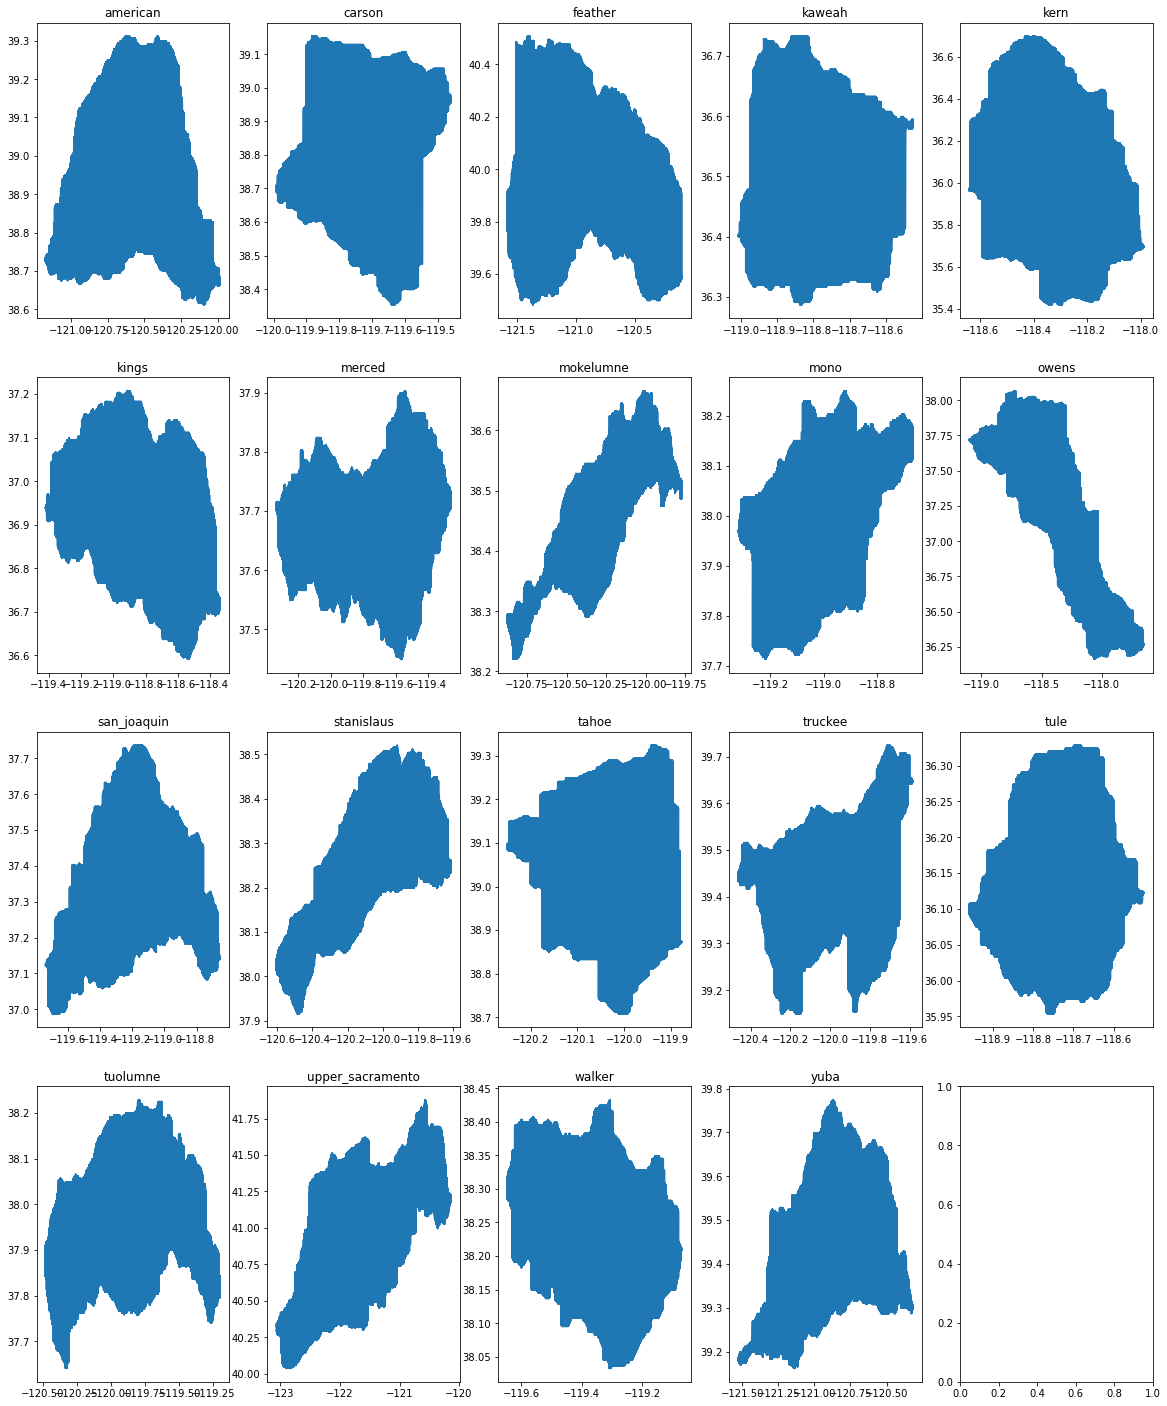

In [105]:
f,ax=plt.subplots(4,5,figsize=(20,25))
axs=ax.flatten()
for i in range(19):
    axs[i].plot(outlines_list[i][0],outlines_list[i][1])
    axs[i].set_title(gdf['name'][i])

In [75]:
watersheds = gpd.read_file('watersheds.gdf')

<AxesSubplot:>

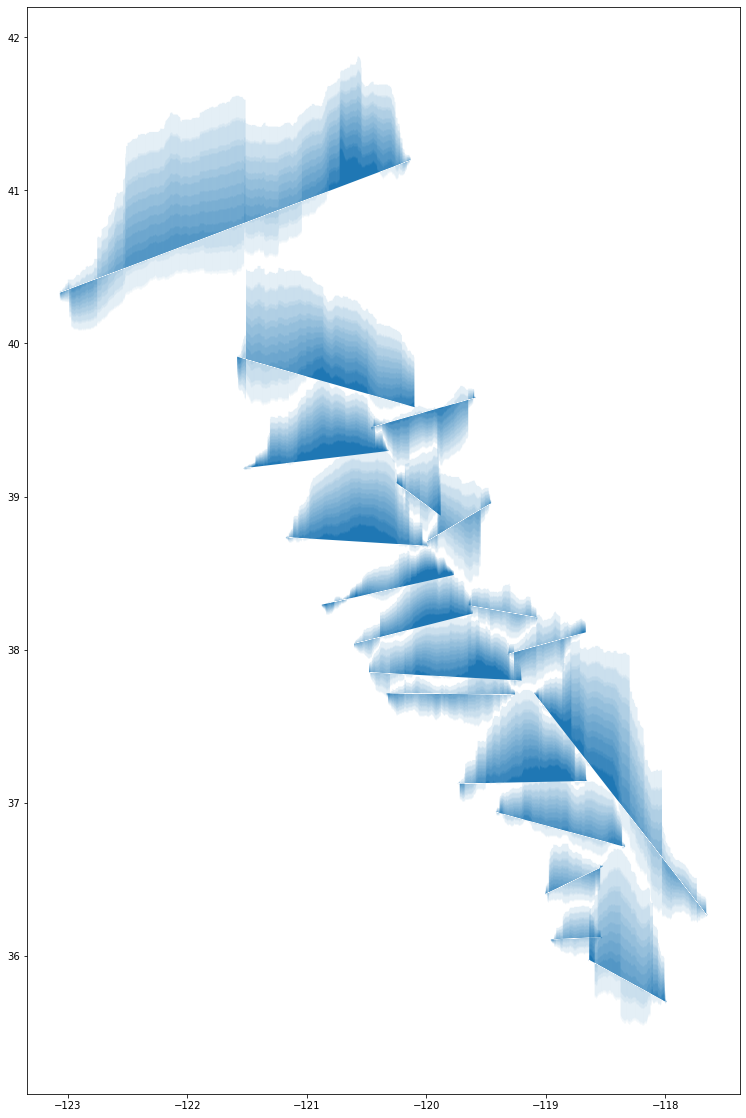

In [116]:
f,ax=plt.subplots(figsize=(20,20)) 
watersheds.plot(ax=ax)

In [122]:
watersheds['geometry'][0].geometry()


AttributeError: 'Polygon' object has no attribute 'geometry'

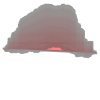

In [127]:
shptest = gpd.read_file('watershed_bounds/american.shp')
shptest['geometry'][0]

In [ ]:
pointInPolys = gpd.tools.sjoin(points, counties, op="within", how='left')


In [148]:
from osgeo import gdal, gdalnumeric, ogr
from PIL import Image, ImageDraw
import os
import numpy as np

def clip_raster(rast, features_path, gt=None, nodata=-9999):
    '''
    Clips a raster (given as either a gdal.Dataset or as a numpy.array
    instance) to a polygon layer provided by a Shapefile (or other vector
    layer). If a numpy.array is given, a "GeoTransform" must be provided
    (via dataset.GetGeoTransform() in GDAL). Returns an array. Clip features
    must be a dissolved, single-part geometry (not multi-part). Modified from:

    http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    #clip-a-geotiff-with-shapefile

    Arguments:
        rast            A gdal.Dataset or a NumPy array
        features_path   The path to the clipping features
        gt              An optional GDAL GeoTransform to use instead
        nodata          The NoData value; defaults to -9999.
    '''
    def array_to_image(a):
        '''
        Converts a gdalnumeric array to a Python Imaging Library (PIL) Image.
        '''
        i = Image.fromstring('L',(a.shape[1], a.shape[0]),
            (a.astype('b')).tostring())
        return i

    def image_to_array(i):
        '''
        Converts a Python Imaging Library (PIL) array to a gdalnumeric image.
        '''
        a = gdalnumeric.fromstring(i.tobytes(), 'b')
        a.shape = i.im.size[1], i.im.size[0]
        return a

    def world_to_pixel(geo_matrix, x, y):
        '''
        Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
        the pixel location of a geospatial coordinate; from:
        http://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
        '''
        ulX = geo_matrix[0]
        ulY = geo_matrix[3]
        xDist = geo_matrix[1]
        yDist = geo_matrix[5]
        rtnX = geo_matrix[2]
        rtnY = geo_matrix[4]
        pixel = int((x - ulX) / xDist)
        line = int((ulY - y) / xDist)
        return (pixel, line)

    # Can accept either a gdal.Dataset or numpy.array instance
    if not isinstance(rast, np.ndarray):
        gt = rast.GetGeoTransform()
        rast = rast.ReadAsArray()

    # Create an OGR layer from a boundary shapefile
    features = ogr.Open(features_path)
    if features.GetDriver().GetName() == 'ESRI Shapefile':
        lyr = features.GetLayer(os.path.split(os.path.splitext(features_path)[0])[1])

    else:
        lyr = features.GetLayer()

    # Get the first feature
    poly = lyr.GetNextFeature()

    # Convert the layer extent to image pixel coordinates
    minX, maxX, minY, maxY = lyr.GetExtent()
    ulX, ulY = world_to_pixel(gt, minX, maxY)
    lrX, lrY = world_to_pixel(gt, maxX, minY)

    # Calculate the pixel size of the new image
    pxWidth = int(lrX - ulX)
    pxHeight = int(lrY - ulY)

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # In such a case... ulY ends up being negative--can't have that!
        iY = ulY
        ulY = 0

    # Multi-band image?
    # try:
    #     #clip = rast[:, ulY:lrY, ulX:lrX]

    # except IndexError:
    clip = rast[ulY:lrY, ulX:lrX]

    # Create a new geomatrix for the image
    gt2 = list(gt)
    gt2[0] = minX
    gt2[3] = maxY

    # Map points to pixels for drawing the boundary on a blank 8-bit,
    #   black and white, mask image.
    points = []
    pixels = []
    geom = poly.GetGeometryRef()
    pts = geom.GetGeometryRef(0)

    for p in range(pts.GetPointCount()):
        points.append((pts.GetX(p), pts.GetY(p)))

    for p in points:
        pixels.append(world_to_pixel(gt2, p[0], p[1]))

    raster_poly = Image.new('L', (pxWidth, pxHeight), 1)
    rasterize = ImageDraw.Draw(raster_poly)
    rasterize.polygon(pixels, 0) # Fill with zeroes

    # If the clipping features extend out-of-bounds and ABOVE the raster...
    if gt[3] < maxY:
        # The clip features were "pushed down" to match the bounds of the
        #   raster; this step "pulls" them back up
        premask = image_to_array(raster_poly)
        # We slice out the piece of our clip features that are "off the map"
        mask = np.ndarray((premask.shape[-2] - abs(iY), premask.shape[-1]), premask.dtype)
        mask[:] = premask[abs(iY):, :]
        mask.resize(premask.shape) # Then fill in from the bottom

        # Most importantly, push the clipped piece down
        gt2[3] = maxY - (maxY - gt[3])

    else:
        mask = image_to_array(raster_poly)

    # Clip the image using the mask
    try:
        clip = gdalnumeric.choose(mask, (clip, nodata))

    # If the clipping features extend out-of-bounds and BELOW the raster...
    except ValueError:
        # We have to cut the clipping features to the raster!
        rshp = list(mask.shape)
        if mask.shape[-2] != clip.shape[-2]:
            rshp[0] = clip.shape[-2]

        if mask.shape[-1] != clip.shape[-1]:
            rshp[1] = clip.shape[-1]

        mask.resize(*rshp, refcheck=False)

        clip = gdalnumeric.choose(mask, (clip, nodata))

    return (clip, ulX, ulY, gt2)


In [134]:
# find all modis files downloaded to modis_dir within individual directories and add them to a list with the full location
modis_dir = 'C:/Users/Marianne/e4ftl01.cr.usgs.gov/MOLT/MOD16A2.006/'
folders = os.listdir(modis_dir)
modis_files =[]
for d in folders:
    modis_files.append(modis_dir+d+'/'+os.listdir(modis_dir+d)[0])
#modis_files
modis = rxr.open_rasterio(modis_files[1],decode_times=False)
rast =modis['PET_500m']
rast=np.array(rast)
features = gpd.read_file('watershed_bounds/american.shp')

clip_raster(rast,features)

RuntimeError: not a string

In [149]:
rast = gdal.Open(modis_files[1],gdal.GA_ReadOnly)
clip_raster(rast,'watershed_bounds/american.shp')

TypeError: 'NoneType' object is not subscriptable

TypeError: 'Dataset' object is not subscriptable

In [142]:
rast

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001A9A5772990> >